In [1]:
import cv2
import numpy as np
import os
from PIL import Image
import shutil
import random
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms as transform
from torch.utils.data import DataLoader


## Data preprocessing


In [2]:
data_dir = 'datasets/mri_brain_multi'
print(os.listdir(data_dir))


['Testing', 'Training']


In [3]:
source_root = 'datasets/mri_brain_detection'  
target_root = 'datasets/mri_brain_detection_reduced' 
subsets = ['train', 'valid', 'test'] 
n_samples = {
    'train': 100,  # Number of images for training
    'valid': 20,   # Number of images for validation
    'test': 20     # Number of images for test
}

random.seed(42)

for subset in subsets:
    
    src_img_path = os.path.join(source_root, subset, 'images')
    src_lab_path = os.path.join(source_root, subset, 'labels')
    
    dst_img_path = os.path.join(target_root, subset, 'images')
    dst_lab_path = os.path.join(target_root, subset, 'labels')
    
    os.makedirs(dst_img_path, exist_ok=True)
    os.makedirs(dst_lab_path, exist_ok=True)
    
    if os.path.exists(src_img_path):
        # List the images
        all_images = [f for f in os.listdir(src_img_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Random selection
        n_to_sample = min(len(all_images), n_samples[subset])
        selected_images = random.sample(all_images, n_to_sample)
        
        for img_name in selected_images:
            # Copy the image
            shutil.copy(os.path.join(src_img_path, img_name), 
                        os.path.join(dst_img_path, img_name))
            
            # Copy the matching label (.txt)
            label_name = os.path.splitext(img_name)[0] + '.txt'
            src_label = os.path.join(src_lab_path, label_name)
            
            if os.path.exists(src_label):
                shutil.copy(src_label, os.path.join(dst_lab_path, label_name))
            else:
                print(f"Warning : Missing label for {img_name}")

# Copy the data.yaml file (useful for YOLO)
src_yaml = os.path.join(source_root, 'data.yaml')
if os.path.exists(src_yaml):
    shutil.copy(src_yaml, os.path.join(target_root, 'data.yaml'))
    print("File data.yaml copied.")

print(f"Detection dataset reduced created in '{target_root}'.")

File data.yaml copied.
Detection dataset reduced created in 'datasets/mri_brain_detection_reduced'.


In [4]:
class AddGaussianNoise(object):
    """
    Add a standard Gaussian noise."""
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

class AddRicianNoise(object):
    """
    Add a standard Rician noise.
    Formula : sqrt((I + n_re)^2 + n_im^2)
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def __call__(self, tensor):
        noise_shape = [1, tensor.size(1), tensor.size(2)]
        
        n_re = torch.randn(noise_shape) * self.sigma
        n_im = torch.randn(noise_shape) * self.sigma
        
        noisy = torch.sqrt((tensor + n_re)**2 + n_im**2)
        
        return noisy

In [5]:
def generate_noisy_yolo_dataset(source_dir, target_dir, noise_type=None, sigma=0.05):
    """
    Parcourt un dataset YOLO et crée une copie avec du bruit appliqué aux images.
    """
    # Pipeline de transformation
    trans_list = [transform.Grayscale(1), transform.ToTensor()]
    if noise_type == 'gaussian':
        trans_list.append(AddGaussianNoise(std=sigma))
    elif noise_type == 'rician':
        trans_list.append(AddRicianNoise(sigma=sigma))
    
    # On ne normalise pas ici car YOLO s'en charge en interne (0-255 -> 0-1)
    pipeline = transform.Compose(trans_list)

    for subset in ['train', 'valid', 'test']:
        img_src = os.path.join(source_dir, subset, 'images')
        img_dst = os.path.join(target_dir, subset, 'images')
        lab_src = os.path.join(source_dir, subset, 'labels')
        lab_dst = os.path.join(target_dir, subset, 'labels')
        
        os.makedirs(img_dst, exist_ok=True)
        os.makedirs(lab_dst, exist_ok=True)

        if not os.path.exists(img_src): continue

        for img_name in os.listdir(img_src):
            # 1. Traitement de l'Image
            path = os.path.join(img_src, img_name)
            img = Image.open(path).convert('L')
            
            # Application du bruit
            img_tensor = pipeline(img)
            
            # Reconversion en image PIL/Numpy pour sauvegarde
            img_noisy = img_tensor.squeeze().numpy()
            img_noisy = (np.clip(img_noisy, 0, 1) * 255).astype(np.uint8)
            
            cv2.imwrite(os.path.join(img_dst, img_name), img_noisy)

            # 2. Copie du Label (inchangé)
            label_name = os.path.splitext(img_name)[0] + '.txt'
            if os.path.exists(os.path.join(lab_src, label_name)):
                shutil.copy(os.path.join(lab_src, label_name), os.path.join(lab_dst, label_name))

# --- GÉNÉRATION DES 3 SCÉNARIOS ---
sigma_val = 0.05
source = 'datasets/mri_brain_detection_reduced'

# Scenario 1: Baseline (Just grayscale)
generate_noisy_yolo_dataset(source, 'yolo/yolo_base', noise_type=None)

# Scenario 2: Gaussian
generate_noisy_yolo_dataset(source, 'yolo/yolo_gauss', noise_type='gaussian', sigma=sigma_val)

# Scenario 3: Rician (Votre modèle)
generate_noisy_yolo_dataset(source, 'yolo/yolo_rice', noise_type='rician', sigma=sigma_val)

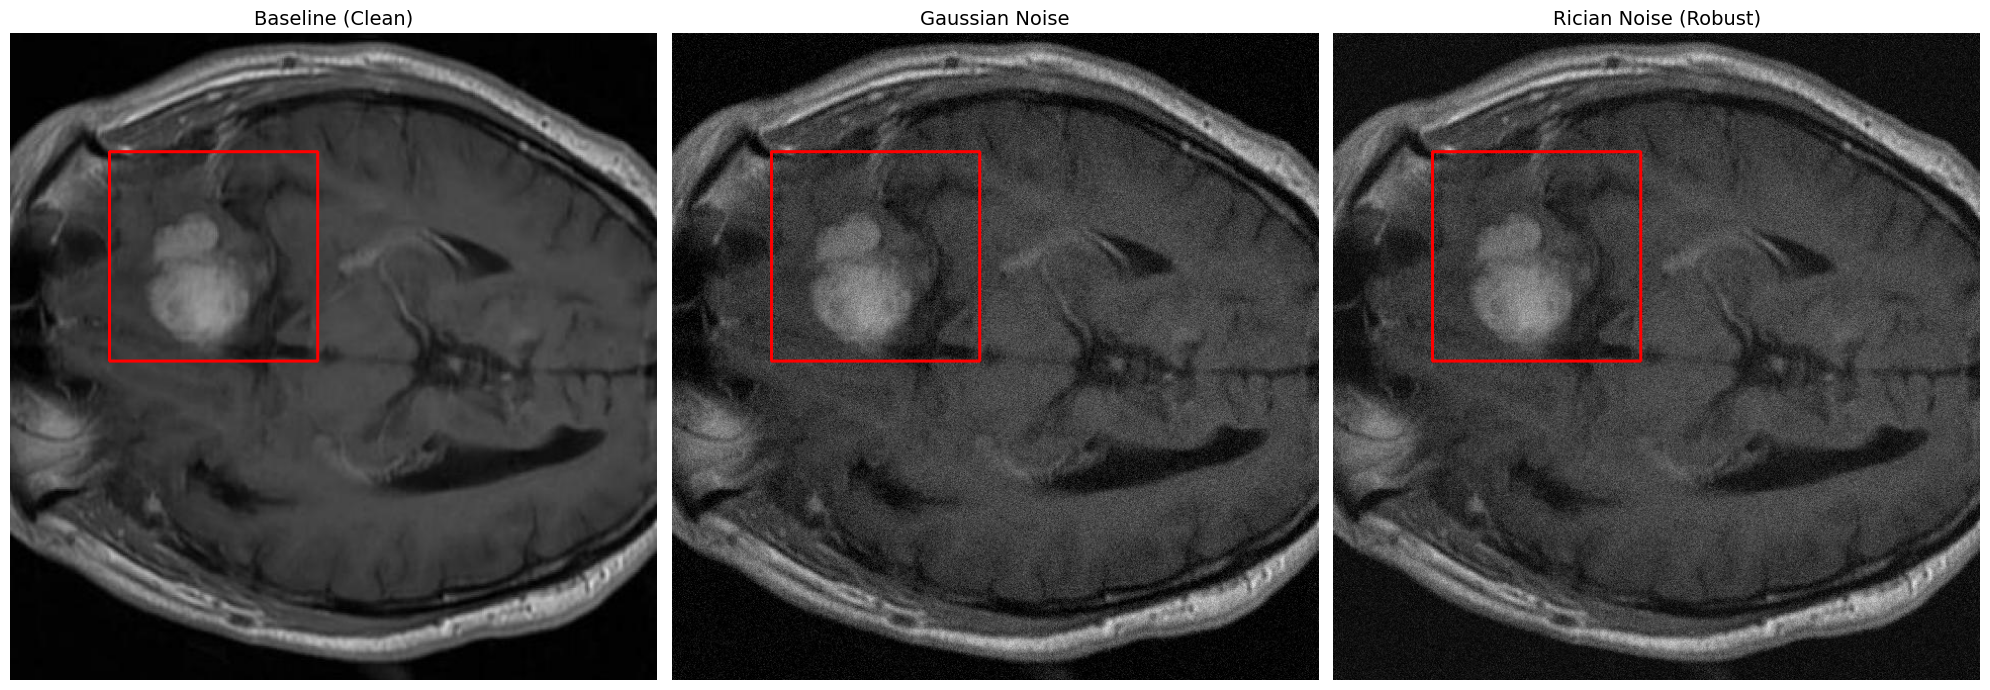

In [6]:
import cv2
import matplotlib.pyplot as plt
import os

def visualize_yolo_scenarios(image_name, base_folder, gauss_folder, rice_folder, subset='train'):
    """
    Affiche l'image choisie avec ses labels pour les 3 scénarios de bruit.
    """
    folders = [base_folder, gauss_folder, rice_folder]
    titles = ["Baseline (Clean)", "Gaussian Noise", "Rician Noise (Robust)"]
    
    plt.figure(figsize=(20, 8))
    
    for i, folder in enumerate(folders):
        # Chemins des fichiers
        img_path = os.path.join(folder, subset, 'images', image_name)
        label_path = os.path.join(folder, subset, 'labels', os.path.splitext(image_name)[0] + '.txt')
        
        # Chargement de l'image avec OpenCV
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Lecture et dessin des Bounding Boxes
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.split()
                    # Format YOLO : class x_center y_center width height (normalisé 0-1)
                    cls, x, y, nw, nh = map(float, parts[:5])
                    
                    # Conversion en coordonnées pixels
                    x1 = int((x - nw/2) * w)
                    y1 = int((y - nh/2) * h)
                    x2 = int((x + nw/2) * w)
                    y2 = int((y + nh/2) * h)
                    
                    # Dessin du rectangle (Rouge pour la visibilité)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(titles[i], fontsize=14)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- UTILISATION ---

base_folder = 'yolo/yolo_base'
gauss_folder = 'yolo/yolo_gauss'
rice_folder = 'yolo/yolo_rice'

# Remplacez par le nom d'une image présente dans vos dossiers
example_img = os.listdir('yolo/yolo_base/train/images')[0] 
visualize_yolo_scenarios(example_img, base_folder, gauss_folder, rice_folder)

In [13]:
import yaml
import os
from ultralytics import YOLO

def prepare_and_train_yolo(scenario_name, data_dir, project_folder, epochs=4):
    """
    Met à jour le YAML pour pointer vers le bon dossier de bruit et lance l'entraînement.
    """
    source_yaml = 'yolo/data.yaml'  # Votre fichier copié
    target_yaml = os.path.join(data_dir, 'data_temp.yaml') # YAML spécifique au scénario
    
    # 1. Charger et modifier le chemin dans le YAML
    with open(source_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # On force le chemin vers le dossier spécifique (yolo_base, yolo_rice, etc.)
    data_config['path'] = os.path.abspath(data_dir)
    
    # Sauvegarde du YAML temporaire dans le dossier de données
    with open(target_yaml, 'w') as f:
        yaml.dump(data_config, f)
        
    # 2. Lancement de l'entraînement
    model = YOLO('yolo11n.pt')
    results = model.train(
        data=target_yaml,
        epochs=epochs,
        imgsz=224,
        project=project_folder,
        name=scenario_name,
        device='cpu'  # Assurez-vous d'avoir un GPU, sinon mettez 'cpu'
    )
    return model, results



In [15]:
# --- Lancement des entraînements corrigés ---

n_epochs_yolo = 4
project_folder = "MRI_Brain_Detection"

# 1. BASELINE
model_yolo_base, results_base = prepare_and_train_yolo(
    "Baseline", 'yolo/yolo_base', project_folder, epochs=n_epochs_yolo
)

# 2. GAUSSIEN
model_yolo_gauss, results_gauss = prepare_and_train_yolo(
    "Gaussian", 'yolo/yolo_gauss', project_folder, epochs=n_epochs_yolo
)

# 3. RICIEN
model_yolo_rice, results_rice = prepare_and_train_yolo(
    "Rician", 'yolo/yolo_rice', project_folder, epochs=n_epochs_yolo
)

Ultralytics 8.4.9  Python-3.13.9 torch-2.9.1+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo/yolo_base\data_temp.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=4, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=Baseline3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

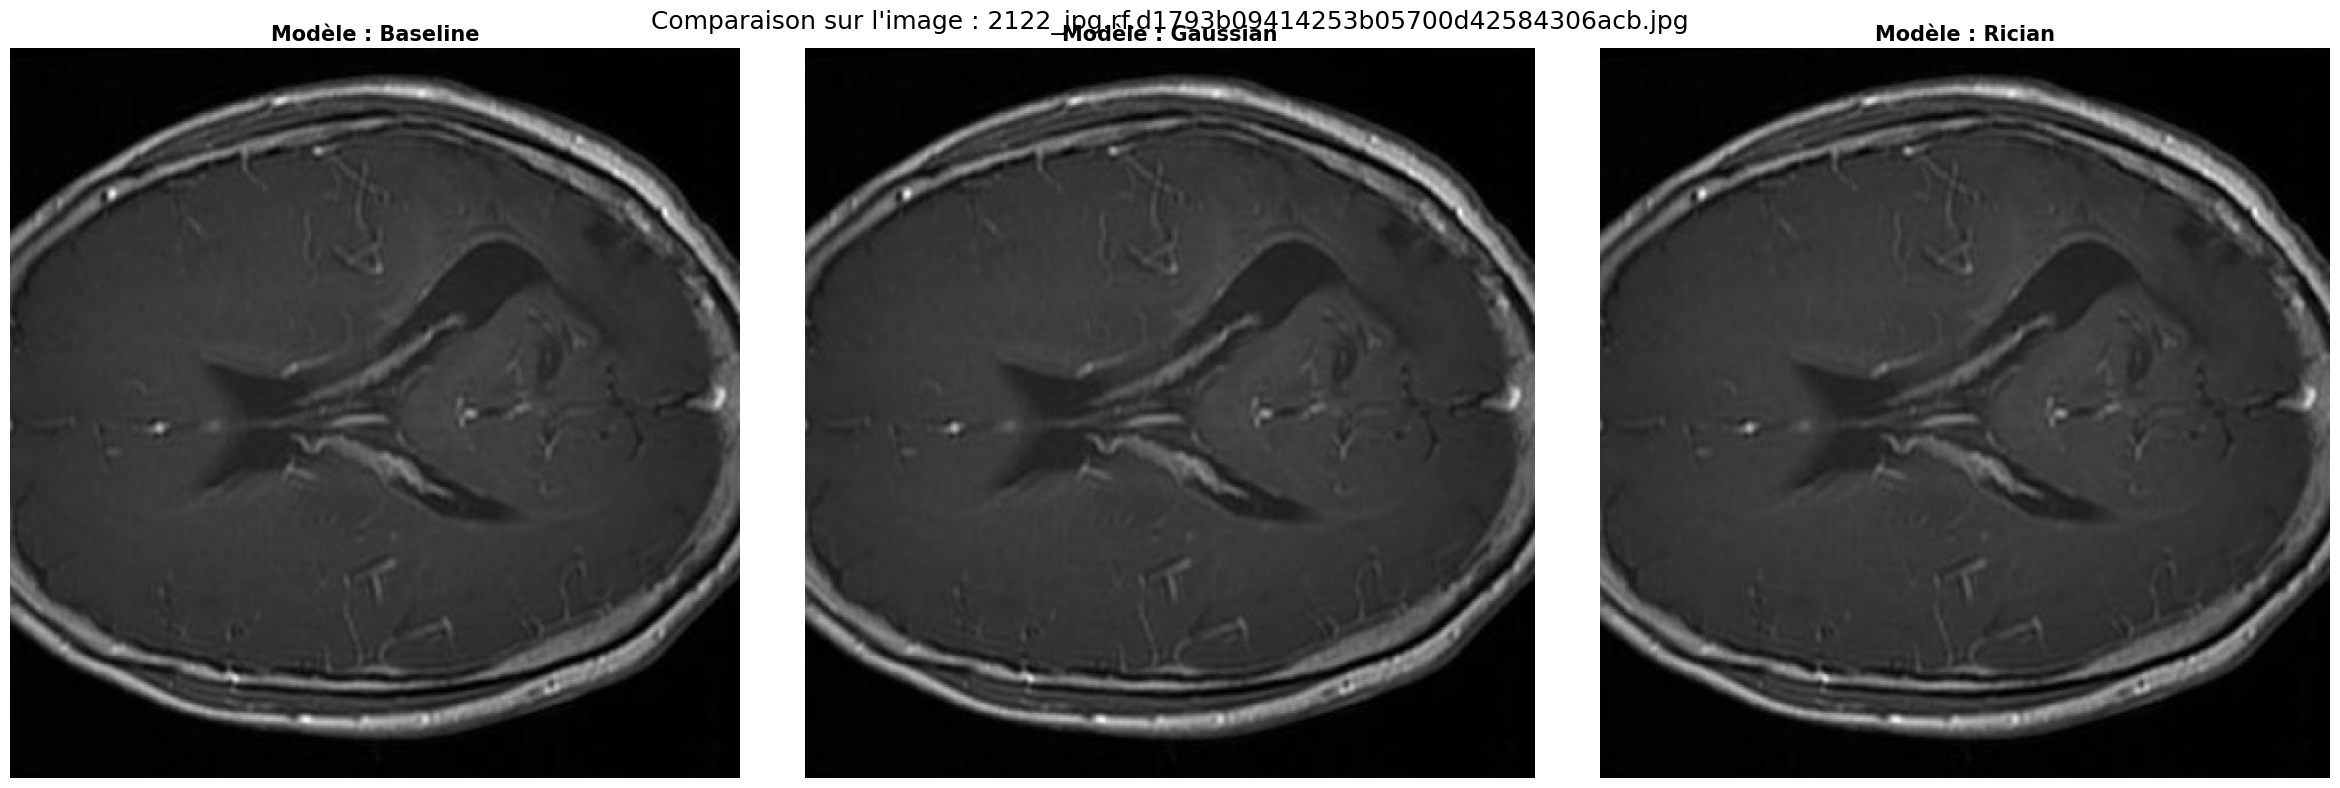

In [22]:
import cv2
import matplotlib.pyplot as plt
import os
import random
from ultralytics import YOLO

def compare_all_yolo_scenarios(test_dir, model_paths):
    """
    Sélectionne une image au hasard et compare les 3 modèles YOLO.
    model_paths: dict {'Baseline': path, 'Gaussian': path, 'Rician': path}
    """
    # 1. Sélection aléatoire d'une image de test
    test_images_path = os.path.join(test_dir, 'images')
    available_images = [f for f in os.listdir(test_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not available_images:
        print("Erreur : Aucune image trouvée dans le dossier de test.")
        return

    random_image = random.choice(available_images)
    image_path = os.path.join(test_images_path, random_image)
    
    # 2. Préparation de l'affichage
    plt.figure(figsize=(24, 8))
    
    for i, (name, path) in enumerate(model_paths.items()):
        if not os.path.exists(path):
            print(f"Attention : Le modèle {name} est introuvable à l'adresse {path}")
            continue
            
        # Chargement et prédiction
        model = YOLO(path)
        results = model.predict(image_path, imgsz=224, conf=0.25, verbose=False)
        
        # Génération de l'image avec les boîtes (format BGR)
        annotated_img = results[0].plot()
        # Conversion BGR -> RGB pour Matplotlib
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(annotated_img)
        plt.title(f"Modèle : {name}", fontsize=15, fontweight='bold')
        plt.axis('off')

    plt.suptitle(f"Comparaison sur l'image : {random_image}", fontsize=18)
    plt.tight_layout()
    plt.show()

# --- CONFIGURATION ET APPEL ---

# Chemins vers vos fichiers de poids 'best.pt'
paths = {
    'Baseline': 'runs/detect/MRI_Brain_Detection/Baseline/weights/best.pt',
    'Gaussian': 'runs/detect/MRI_Brain_Detection/Gaussian/weights/best.pt',
    'Rician':   'runs/detect/MRI_Brain_Detection/Rician/weights/best.pt'
}

# On utilise le dossier de test du scénario baseline (images propres)
# ou yolo_rice (images bruitées) pour voir comment ils réagissent
test_folder = 'yolo/yolo_base/test' 

compare_all_yolo_scenarios(test_folder, paths)